In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_cv

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
dog = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*'
cat = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg'

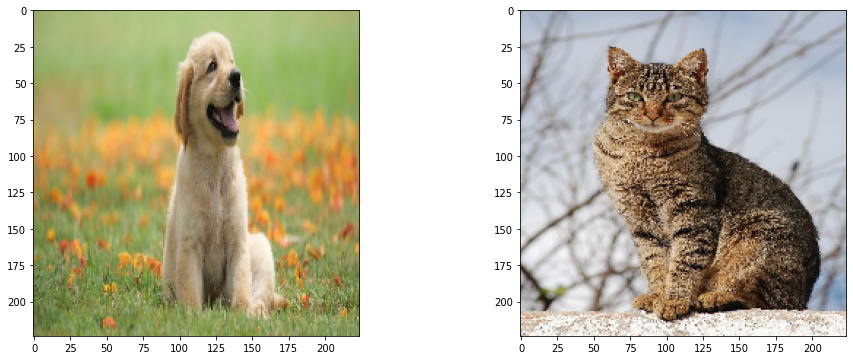

In [3]:
import PIL
import urllib

def url_to_array(url):
    req = urllib.request.urlopen(url)
    arr = np.array(bytearray(req.read()), dtype=np.int8)
    arr = cv2.imdecode(arr, -1)
    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    arr = cv2.resize(arr, (224, 224))
    return arr


dog_img = url_to_array(dog)
cat_img = url_to_array(cat)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].imshow(dog_img)
ax[1].imshow(cat_img)

In [4]:
images = np.array([dog_img, cat_img])
labels = np.array([0., 1.])

In [5]:
rand_augment = keras_cv.layers.RandAugment(value_range=(0, 255))
cutmix = keras_cv.layers.CutMix()
mixup = keras_cv.layers.MixUp()

In [6]:
randaug_imgs = rand_augment(images)
cutmix_imgs = cutmix({"images": images, "labels": labels})
mixup_imgs = mixup({"images": images, "labels": labels})

In [7]:
def visualize(images):
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    for index, img in enumerate(images):
        ax[index].imshow(img.numpy().astype('int'))
        ax[index].axis('off')

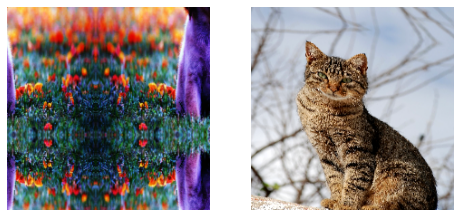

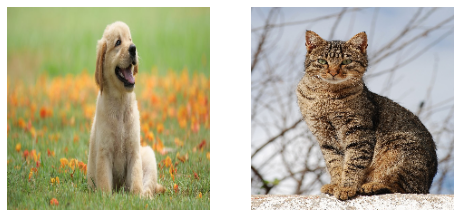

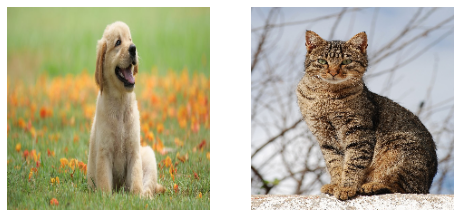

In [8]:
visualize(randaug_imgs)
visualize(cutmix_imgs["images"])
visualize(mixup_imgs["images"])

In [9]:
def preprocess_img(img, label):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.cast(img, tf.float32)
    return {"images": img, "labels": label}

data = tf.data.Dataset.from_tensor_slices((images, labels)).map(preprocess_img).batch(2)

In [10]:
randaug_imgs = data.map(rand_augment)
cutmix_imgs = data.map(cutmix)
mixup_imgs = data.map(mixup)

d:\ml-learning\ml_env\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


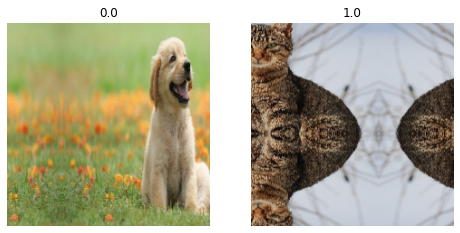

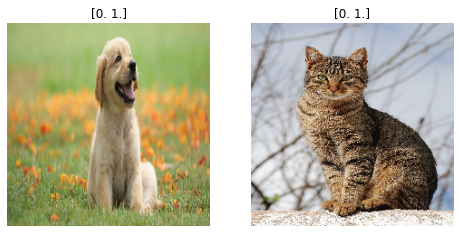

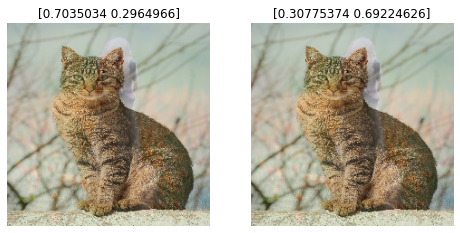

In [11]:
def visualize(dataset):
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    for sample in dataset:
        images = sample["images"]
        labels = sample["labels"]
        for index, img in enumerate(images):
            ax[index].imshow(img.numpy().astype('int'))
            ax[index].axis('off')
            ax[index].set_title(labels[index].numpy())

visualize(randaug_imgs)
visualize(cutmix_imgs)
visualize(mixup_imgs)

In [12]:
import tensorflow_datasets as tfds

(train_set, valid_set, test_set), info = tfds.load("imagenette", 
                                           split=["train[:50%]", "validation", "train[70%:]"],
                                           as_supervised=True, with_info=True)

class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
print(f'Class names: {class_names}')
print('Num of classes:', n_classes)

print("Train set size:", len(train_set))
print("Test set size:", len(test_set))
print("Valid set size:", len(valid_set))

Class names: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
Num of classes: 10
Train set size: 4734
Test set size: 2841
Valid set size: 3925


In [13]:
import random

def preprocess(img, label):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.cast(img, tf.float32)
    label = tf.one_hot(label, n_classes)
    return {"images": img, "labels": label}

def prep_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

def cutmix_or_mixup(samples):
    if random.randrange(2) == 0:
        samples = keras_cv.layers.CutMix()(samples)
    else:
        samples = keras_cv.layers.MixUp()(samples)
    return samples


train_set_na = train_set.map(preprocess).batch(32).map(prep_for_model).prefetch(tf.data.AUTOTUNE)
test_set_na = test_set.map(preprocess).batch(32).map(prep_for_model).prefetch(tf.data.AUTOTUNE)
valid_set_na = valid_set.map(preprocess).batch(32).map(prep_for_model).prefetch(tf.data.AUTOTUNE)

train_set_aug = train_set.map(preprocess).batch(32).map(cutmix_or_mixup).map(prep_for_model).prefetch(tf.data.AUTOTUNE)
test_set_aug = test_set.map(preprocess).batch(32).map(prep_for_model).prefetch(tf.data.AUTOTUNE)
valid_set_aug = valid_set.map(preprocess).batch(32).map(prep_for_model).prefetch(tf.data.AUTOTUNE)

In [14]:
for x in train_set_aug.take(1):
    print(x[1].shape)

(32, 10)


In [15]:
for x in train_set_na.take(1):
    print(x[1].shape)

(32, 10)


In [16]:
value_range = (0, 255)

rand_aug = keras_cv.layers.RandomAugmentationPipeline(
    layers=[keras_cv.layers.Grayscale(), 
            keras_cv.layers.AutoContrast(value_range=value_range),
            keras_cv.layers.AutoContrast(value_range=value_range),
                                             # Either 0.1 or 0.5
            keras_cv.layers.RandomColorDegeneration((0.1, 0.5)),
            keras_cv.layers.RandomHue(0.5, value_range=value_range),
            keras_cv.layers.RandomSaturation(0.5)],  
            augmentations_per_image=5)

data_aug_pipeline = keras.Sequential([
    keras_cv.layers.RandAugment(value_range=value_range, magnitude=0.3)
])

In [17]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(None, None, 3)),
    keras.applications.EfficientNetV2B0(weights=None, include_top=False),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(n_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

In [18]:
history = model.fit(train_set_na, 
                        epochs=100,
                        validation_data=valid_set_na)

Epoch 1/100
148/148 [==============================] - 48s 254ms/step - loss: 2.1633 - accuracy: 0.2423 - val_loss: 1.7836 - val_accuracy: 0.3781
Epoch 2/100
148/148 [==============================] - 34s 233ms/step - loss: 1.7641 - accuracy: 0.3743 - val_loss: 1.7432 - val_accuracy: 0.4161
Epoch 3/100
148/148 [==============================] - 35s 233ms/step - loss: 1.5131 - accuracy: 0.4896 - val_loss: 1.5535 - val_accuracy: 0.4828
Epoch 4/100
148/148 [==============================] - 34s 233ms/step - loss: 1.3131 - accuracy: 0.5513 - val_loss: 1.4641 - val_accuracy: 0.5279
Epoch 5/100
148/148 [==============================] - 34s 233ms/step - loss: 1.1179 - accuracy: 0.6225 - val_loss: 1.4056 - val_accuracy: 0.5748
Epoch 6/100
148/148 [==============================] - 35s 234ms/step - loss: 0.9683 - accuracy: 0.6806 - val_loss: 1.5461 - val_accuracy: 0.5516
Epoch 7/100
148/148 [==============================] - 35s 234ms/step - loss: 0.8194 - accuracy: 0.7349 - val_loss: 1.4330 -

Epoch 57/100
148/148 [==============================] - 35s 237ms/step - loss: 0.0489 - accuracy: 0.9858 - val_loss: 2.0712 - val_accuracy: 0.6583
Epoch 58/100
148/148 [==============================] - 35s 235ms/step - loss: 0.0372 - accuracy: 0.9869 - val_loss: 2.2016 - val_accuracy: 0.6632
Epoch 59/100
148/148 [==============================] - 35s 234ms/step - loss: 0.0373 - accuracy: 0.9896 - val_loss: 2.0728 - val_accuracy: 0.6718
Epoch 60/100
148/148 [==============================] - 35s 234ms/step - loss: 0.0247 - accuracy: 0.9916 - val_loss: 2.1220 - val_accuracy: 0.6744
Epoch 61/100
148/148 [==============================] - 35s 234ms/step - loss: 0.0321 - accuracy: 0.9882 - val_loss: 2.1776 - val_accuracy: 0.6708
Epoch 62/100
148/148 [==============================] - 35s 234ms/step - loss: 0.0506 - accuracy: 0.9850 - val_loss: 2.1953 - val_accuracy: 0.6665
Epoch 63/100
148/148 [==============================] - 35s 234ms/step - loss: 0.0628 - accuracy: 0.9782 - val_loss: 2

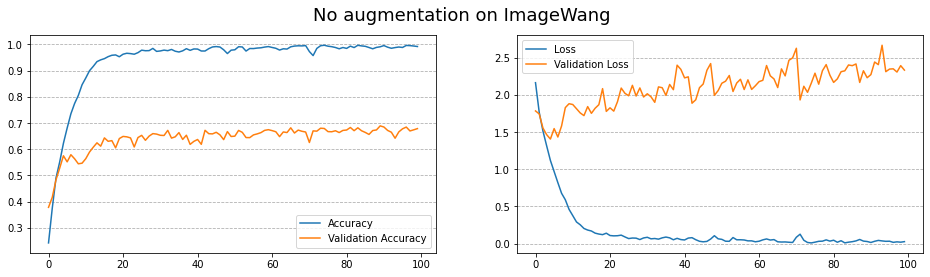

In [19]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('No augmentation on ImageWang', fontsize=18)

ax[0].plot(acc, label='Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].grid(axis='y', linestyle='--')

ax[1].plot(loss, label='Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].grid(axis='y', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

In [20]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(None, None, 3)),
    data_aug_pipeline,
    keras.applications.EfficientNetV2B0(weights=None, include_top=False),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(n_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

In [21]:
history2 = model.fit(train_set_na, 
                        epochs=100,
                        validation_data=valid_set_na)

Epoch 1/100
148/148 [==============================] - 75s 439ms/step - loss: 2.4020 - accuracy: 0.1753 - val_loss: 3.0686 - val_accuracy: 0.2744
Epoch 2/100
148/148 [==============================] - 64s 430ms/step - loss: 2.1399 - accuracy: 0.2376 - val_loss: 1.9115 - val_accuracy: 0.3248
Epoch 3/100
148/148 [==============================] - 64s 431ms/step - loss: 1.9927 - accuracy: 0.3093 - val_loss: 1.8295 - val_accuracy: 0.3740
Epoch 4/100
148/148 [==============================] - 64s 432ms/step - loss: 1.8451 - accuracy: 0.3591 - val_loss: 1.5616 - val_accuracy: 0.4670
Epoch 5/100
148/148 [==============================] - 64s 429ms/step - loss: 1.7737 - accuracy: 0.3832 - val_loss: 1.4936 - val_accuracy: 0.4838
Epoch 6/100
148/148 [==============================] - 63s 429ms/step - loss: 1.6329 - accuracy: 0.4466 - val_loss: 1.4395 - val_accuracy: 0.5096
Epoch 7/100
148/148 [==============================] - 64s 432ms/step - loss: 1.5893 - accuracy: 0.4673 - val_loss: 1.4006 -

Epoch 57/100
148/148 [==============================] - 64s 430ms/step - loss: 0.3904 - accuracy: 0.8707 - val_loss: 0.6836 - val_accuracy: 0.7959
Epoch 58/100
148/148 [==============================] - 64s 432ms/step - loss: 0.4067 - accuracy: 0.8665 - val_loss: 0.6046 - val_accuracy: 0.8245
Epoch 59/100
148/148 [==============================] - 64s 430ms/step - loss: 0.3972 - accuracy: 0.8762 - val_loss: 0.5812 - val_accuracy: 0.8250
Epoch 60/100
148/148 [==============================] - 64s 430ms/step - loss: 0.3531 - accuracy: 0.8849 - val_loss: 0.6329 - val_accuracy: 0.8189
Epoch 61/100
148/148 [==============================] - 64s 434ms/step - loss: 0.3672 - accuracy: 0.8826 - val_loss: 0.6079 - val_accuracy: 0.8257
Epoch 62/100
148/148 [==============================] - 64s 432ms/step - loss: 0.3973 - accuracy: 0.8728 - val_loss: 0.6138 - val_accuracy: 0.8222
Epoch 63/100
148/148 [==============================] - 64s 430ms/step - loss: 0.3525 - accuracy: 0.8830 - val_loss: 0

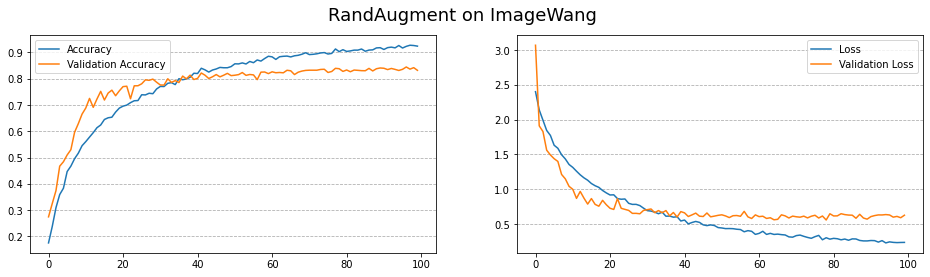

In [22]:
acc, val_acc = history2.history['accuracy'], history2.history['val_accuracy']
loss, val_loss = history2.history['loss'], history2.history['val_loss']
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('RandAugment on ImageWang', fontsize=18)

ax[0].plot(acc, label='Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].grid(axis='y', linestyle='--')

ax[1].plot(loss, label='Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].grid(axis='y', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

In [23]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(None, None, 3)),
    data_aug_pipeline,
    keras.applications.EfficientNetV2B0(weights=None, include_top=False),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(n_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

In [24]:
history3 = model.fit(train_set_aug, 
                        epochs=100,
                        validation_data=valid_set_aug)

Epoch 1/100
148/148 [==============================] - 76s 447ms/step - loss: 2.4251 - accuracy: 0.1318 - val_loss: 2.1492 - val_accuracy: 0.1941
Epoch 2/100
148/148 [==============================] - 66s 445ms/step - loss: 2.2788 - accuracy: 0.1671 - val_loss: 1.9895 - val_accuracy: 0.3045
Epoch 3/100
148/148 [==============================] - 65s 440ms/step - loss: 2.2160 - accuracy: 0.2074 - val_loss: 1.8816 - val_accuracy: 0.3501
Epoch 4/100
148/148 [==============================] - 65s 437ms/step - loss: 2.1714 - accuracy: 0.2370 - val_loss: 1.7785 - val_accuracy: 0.3964
Epoch 5/100
148/148 [==============================] - 65s 438ms/step - loss: 2.1515 - accuracy: 0.2393 - val_loss: 1.7238 - val_accuracy: 0.4145
Epoch 6/100
148/148 [==============================] - 65s 438ms/step - loss: 2.1199 - accuracy: 0.2533 - val_loss: 1.7100 - val_accuracy: 0.4150
Epoch 7/100
148/148 [==============================] - 65s 438ms/step - loss: 2.0768 - accuracy: 0.2755 - val_loss: 1.5971 -

Epoch 57/100
148/148 [==============================] - 65s 439ms/step - loss: 1.5010 - accuracy: 0.5583 - val_loss: 0.6478 - val_accuracy: 0.8344
Epoch 58/100
148/148 [==============================] - 65s 436ms/step - loss: 1.5052 - accuracy: 0.5499 - val_loss: 0.6610 - val_accuracy: 0.8290
Epoch 59/100
148/148 [==============================] - 65s 436ms/step - loss: 1.5115 - accuracy: 0.5482 - val_loss: 0.6353 - val_accuracy: 0.8364
Epoch 60/100
148/148 [==============================] - 65s 438ms/step - loss: 1.5006 - accuracy: 0.5499 - val_loss: 0.6336 - val_accuracy: 0.8403
Epoch 61/100
148/148 [==============================] - 65s 438ms/step - loss: 1.5076 - accuracy: 0.5460 - val_loss: 0.6503 - val_accuracy: 0.8285
Epoch 62/100
148/148 [==============================] - 65s 437ms/step - loss: 1.4804 - accuracy: 0.5687 - val_loss: 0.6674 - val_accuracy: 0.8150
Epoch 63/100
148/148 [==============================] - 65s 436ms/step - loss: 1.4925 - accuracy: 0.5560 - val_loss: 0

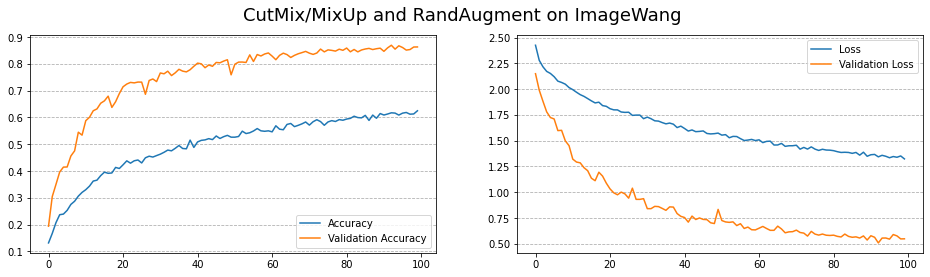

In [25]:
acc, val_acc = history3.history['accuracy'], history3.history['val_accuracy']
loss, val_loss = history3.history['loss'], history3.history['val_loss']
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('CutMix/MixUp and RandAugment on ImageWang', fontsize=18)

ax[0].plot(acc, label='Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].grid(axis='y', linestyle='--')

ax[1].plot(loss, label='Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].grid(axis='y', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

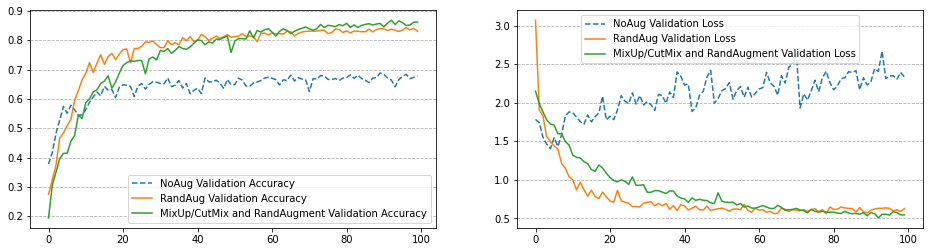

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
#fig.suptitle('CutMix/MixUp and RandAugment on ImageWang', fontsize=18)

#ax[0].plot(history.history['accuracy'], label='NoAug Accuracy')
ax[0].plot(history.history['val_accuracy'], linestyle='--', label='NoAug Validation Accuracy')
#ax[0].plot(history2.history['accuracy'], label='RandAug Accuracy')
ax[0].plot(history2.history['val_accuracy'], label='RandAug Validation Accuracy')
#ax[0].plot(history3.history['accuracy'], label='MixUp/CutMix and RandAugment Accuracy')
ax[0].plot(history3.history['val_accuracy'], label='MixUp/CutMix and RandAugment Validation Accuracy')
ax[0].grid(axis='y', linestyle='--')

#ax[1].plot(history.history['loss'], label='NoAug Loss')
ax[1].plot(history.history['val_loss'], linestyle='--', label='NoAug Validation Loss')
#ax[1].plot(history2.history['loss'], label='RandAug Loss')
ax[1].plot(history2.history['val_loss'], label='RandAug Validation Loss')
#ax[1].plot(history3.history['loss'], label='MixUp/CutMix and RandAugment Loss')
ax[1].plot(history3.history['val_loss'], label='MixUp/CutMix and RandAugment Validation Loss')
ax[1].grid(axis='y', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()